In [6]:
### Heat equation: du/dt = Laplace(u) + f

In [7]:
from fenics import *
import numpy as np
from IPython.display import HTML
import matplotlib.pyplot as plt

In [45]:
def simulate_heat(nx, ny, nt, dt=None, tmax=None):
    if dt is not None and tmax is not None:
        raise ValueError("For a given number of points, dt and tmax cannot both be defined.")
    elif dt is None and tmax is None:
        raise ValueError("For a given number of points, either dt or tmax should be set.")
    elif dt is None:
        dt = tmax/nt
    elif tmax is None:
        tmax = dt*nt
    
    # Mesh setup
    mesh = UnitSquareMesh(nx, ny)
    mesh_info = {'mesh':mesh, 'nx':nx, 'ny':ny, 'nt':nt, 'dt':dt, 'tmax':tmax}

    # Functions setup
    V = FunctionSpace(mesh, 'P', 1)
    u = TrialFunction(V)
    v = TestFunction(V)

    # Boundary setup
    def boundary(x, on_boundary):
        return on_boundary
    alpha = 6
    beta = 1.2
    u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t', degree=2, alpha=alpha, beta=beta, t=0)
    bc = DirichletBC(V, u_D, boundary)

    # Initial values
    t = 0
    u_n = interpolate(u_D, V)

    # Variational problem
    f = Constant(beta - 2 - 2*alpha)
    a = u*v*dx + dt*dot(grad(u), grad(v))*dx
    L = (dt*f+u_n)*v*dx
    
    # Logs
    logs = {'t':[], 'u':[], 'error_max':[]}
    
    #Log initial values
    logs['t'].append(t)
    logs['u'].append(u_n.copy(deepcopy=True))
    logs['error_max'].append(0)
    
    # Solving
    u = Function(V)
    for i in range(nt):
        t += dt
        u_D.t = t
        solve(a == L, u, bc)
        u_n.assign(u)

        #Get error
        vertex_values_u_D = u_D.compute_vertex_values(mesh).reshape(nx+1, ny+1)
        vertex_values_u = u.compute_vertex_values(mesh).reshape(nx+1, ny+1)
        error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))

        # Log current values
        logs['t'].append(t)
        logs['u'].append(u_n.copy(deepcopy=True))
        logs['error_max'].append(0)
        
    return mesh_info, logs

mesh_info, logs = simulate_heat(10, 10, 20, tmax=4.0)

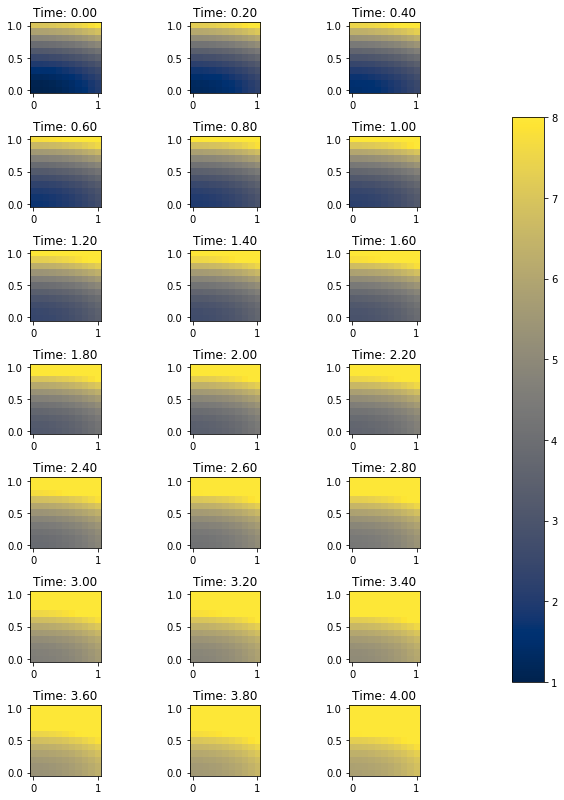

In [68]:
def display_simulation(mesh_info, logs, nplots_max=None, nrows_max=None):

    # Retrieve variables
    mesh = mesh_info['mesh']
    nx = mesh_info['nx']
    ny = mesh_info['ny']
    nt = mesh_info['nt']
    u_hist = logs['u']
    t_hist = logs['t']

    # Default values
    if nplots_max is None: 
        nplots_max = 1e19
    if nrows_max is None:
        nrows_max = 1e19
    nplots = min(nt+1, nplots_max)
    skipper = int(np.ceil((nt+1)/nplots))

    ncols = int(np.ceil(nplots/nrows_max))
    nrows = int(np.ceil(nplots/ncols))
    figsize = [3*ncols, 0.8*nrows*2]     # figure size, inches
    scalemin, scalemax = 1.0, 8.0 #Decided arbitrarily to scale the plots to a standard scale.
                               #Ideally, we would scale everything based on the min and max over all time,
                               #but here we are plotting before doing the entire calculation.

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)


    for i in range(nplots):
        axi = axes.flat[i]
        # i runs from 0 to (nrows*ncols-1)
        # axi is equivalent with ax[rowid][colid]
        vertex_values_u = u_hist[i].compute_vertex_values(mesh).reshape(nx+1, ny+1)
        img = axi.imshow(vertex_values_u, origin='lower', extent=(-0.05, 1.05, -0.05, 1.05), cmap='cividis', vmin=scalemin, vmax=scalemax)
        # write row/col indices as axes' title for identification
        axi.set_title(f'Time: {t_hist[i]:.2f}')


    plt.tight_layout(True)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(img, cax=cbar_ax)

    plt.show()
    
display_simulation(mesh_info, logs, nrows_max=7)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(error_max_hist)
plt.show()

In [22]:
### other

In [54]:
n = 20
rowsmax = 1e21
cols = int(np.ceil(n/rowsmax))
rows = int(np.ceil(n/cols))
(np.arange(rows*cols)+1).reshape(rows, cols)

array([[ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20]])

In [ ]:
uvals = u_hist[0].compute_vertex_values()
xyvals = mesh.coordinates()
xvals = xyvals[:,0]
yvals=xyvals[:,1]

xx = np.linspace(0,1)
yy = np.linspace(0,1)

XX, YY = np.meshgrid(xx,yy)

from scipy.interpolate import griddata
uu = griddata(xyvals, uvals, (XX, YY), method='linear')
plt.imshow(uu, origin='lower', extent=(-5e-3, 1+5e-3, -5e-3, 1+5e-3))

In [73]:
n_plots_max = 10
nrows, ncols = 5, 2  # array of sub-plots
figsize = [6, 8]     # figure size, inches
axes = np.arange(nrows*ncols).reshape(nrows, ncols)

n = 16
vals = np.arange(n)

n_plots = min(nt, n_plots_max)
skipper = int(np.floor(n/n_plots))

j = 0
for i in range(n):
    string = str(i)
    if i % skipper == 0 and j < n_plots:
        axi = axes.flat[j]
        string = string + ' '+str(vals[j])+' : '+str(axi)
        j += 1
    print(string)

0 0 : 0
1 1 : 1
2 2 : 2
3 3 : 3
4 4 : 4
5 5 : 5
6 6 : 6
7 7 : 7
8 8 : 8
9 9 : 9
10
11
12
13
14
15


In [69]:
print(skipper)
print(n_plots)

2
10
